In [1]:
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import OrderedDict
import calendar
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW_Model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize #Минимайзер
from statsmodels.stats.stattools import durbin_watson

# Пробуем прогнозировать индекс потребительских цен с помощью модели Хольта Уинтерса (улучшаем)
Исходные данные - эксель файл, которые содержит данные индекса потребительских цен (ИПЦ) на каждый месяц с 2002 по 2022 год (получается 12 * 21 = 252 значений). Нужно обучить модель Хольта Уинтерса (МХоУ) для прогнозирования ИПЦ на 2 года (24 периода). Предполагается, что сезон равен 1 году, в нем 12 периодов.
**Данные изменены: внесены правки в ряд ячеек (корректировка выбросов), 2000 и 2001 годы удалены, как относительно "нестабильные"**

Были:
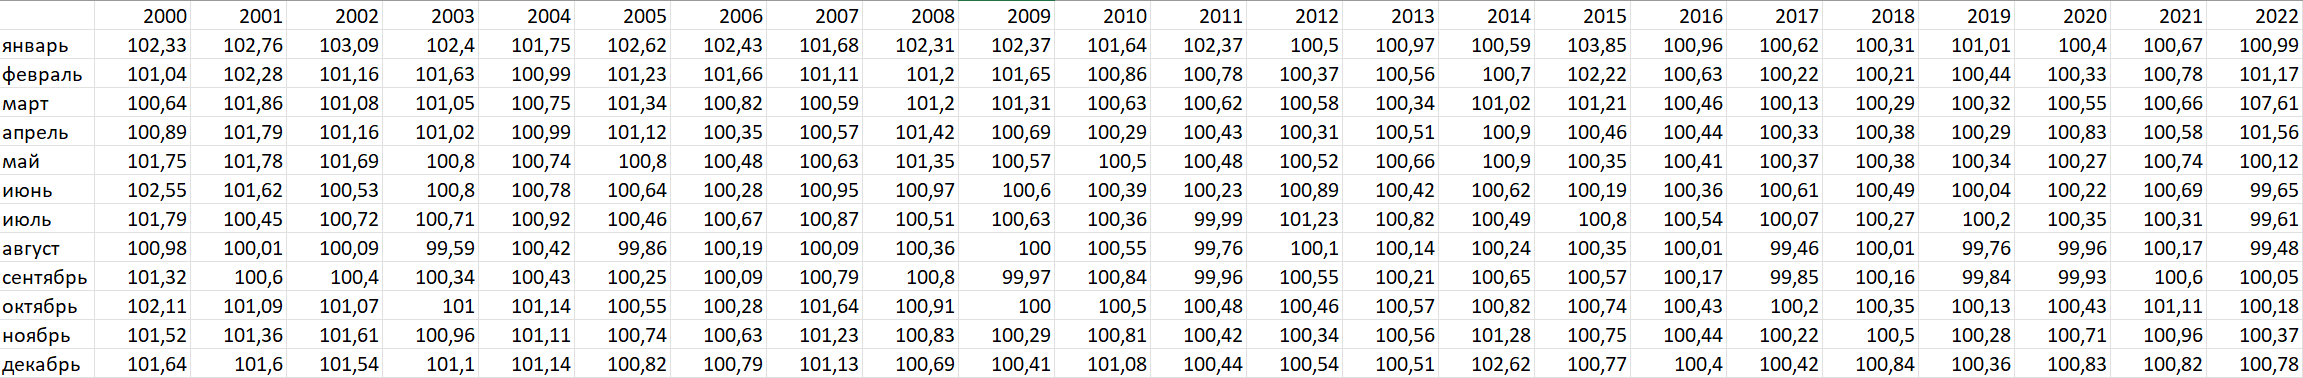
Стали:
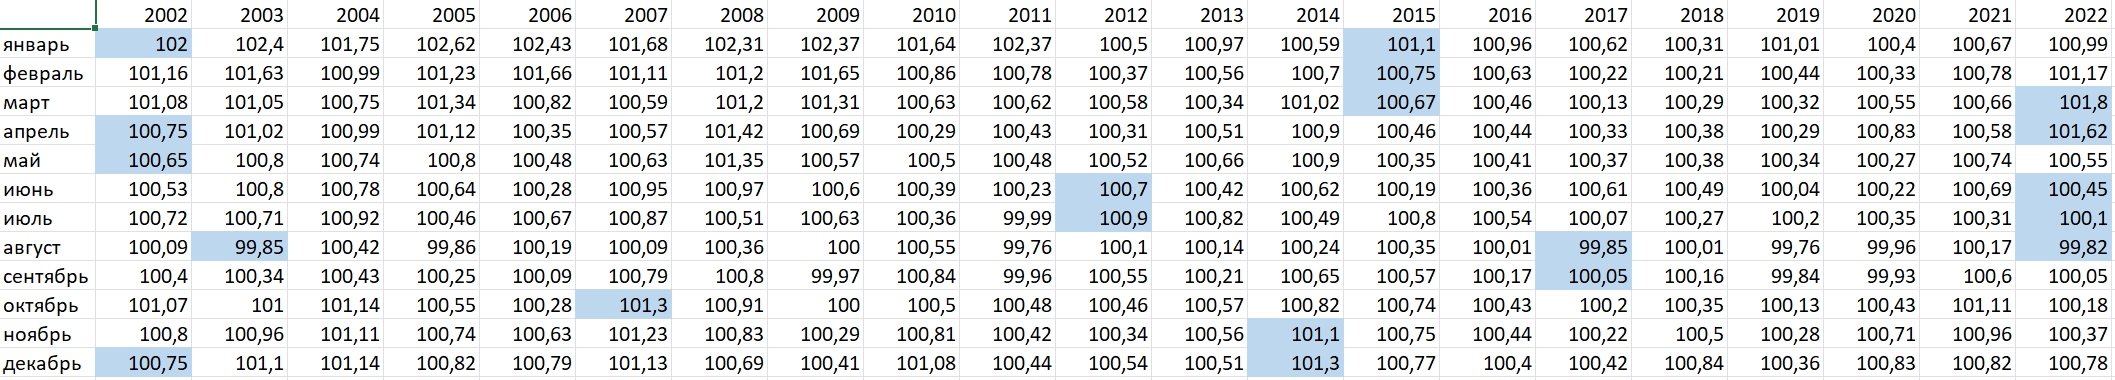

МХоУ выглядит следующим образом:
$$ x_{N+\tau} = (a_N\tau + b_N)F(\tau-L)$$
где:

$N$ - общее количество значений в заденной выборке (до 276);

$L$ - количество периодов в сезоне (12);

$x_{N+\tau}$ - прогнозный период;

$a_N, b_N$ - коэффициенты парной линейной регрессии, оцененные в последнем периоде последнего сезона из заданной выборки;

$F(\tau-L)$  - коэффициент сезонности - мультипликативная корректировка линии регрессии в зависиомсти от периода сезонности.

Параметры модели: $a_N$, $b_N$, $F(...)$ подбираются с применением подхода тройного экспонециального сглаживания.

Начальные значения $a_0$, $b_0$ определяются как коэффициенты парной регрессии, формируемой для всей обучающей выборки

Начальные коэффициенты сезонности $F(-L+1), F(-L+2),..., F(0)$ получаются частными в соответсвующих периодах и взятием от них среднего значения. Далее идет итерационный процесс с применением подхода тройного экспоненциального сглаживания: для трендовой, аддитивной и сезонной компонент с использованием параметров сглаживания (для каждой из них).

## Загружаем данные из экселевского файла

In [2]:
data = pd.read_excel('cpi2002-2022cor.xlsx', index_col='Unnamed: 0')
#пока не поставил второй аргумент (index_col='Unnamed: 0'), данные нормально не считывались

In [3]:
data.columns

Int64Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
            2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
           dtype='int64')

In [4]:
data.shape

(12, 21)

In [5]:
data

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
январь,102.00,102.40,101.75,102.62,102.43,101.68,102.31,102.37,101.64,102.37,...,100.97,100.59,101.10,100.96,100.62,100.31,101.01,100.40,100.67,100.99
февраль,101.16,101.63,100.99,101.23,101.66,101.11,101.20,101.65,100.86,100.78,...,100.56,100.70,100.75,100.63,100.22,100.21,100.44,100.33,100.78,101.17
март,101.08,101.05,100.75,101.34,100.82,100.59,101.20,101.31,100.63,100.62,...,100.34,101.02,100.67,100.46,100.13,100.29,100.32,100.55,100.66,101.80
апрель,100.75,101.02,100.99,101.12,100.35,100.57,101.42,100.69,100.29,100.43,...,100.51,100.90,100.46,100.44,100.33,100.38,100.29,100.83,100.58,101.62
май,100.65,100.80,100.74,100.80,100.48,100.63,101.35,100.57,100.50,100.48,...,100.66,100.90,100.35,100.41,100.37,100.38,100.34,100.27,100.74,100.55
июнь,100.53,100.80,100.78,100.64,100.28,100.95,100.97,100.60,100.39,100.23,...,100.42,100.62,100.19,100.36,100.61,100.49,100.04,100.22,100.69,100.45
июль,100.72,100.71,100.92,100.46,100.67,100.87,100.51,100.63,100.36,99.99,...,100.82,100.49,100.80,100.54,100.07,100.27,100.20,100.35,100.31,100.10
август,100.09,99.85,100.42,99.86,100.19,100.09,100.36,100.00,100.55,99.76,...,100.14,100.24,100.35,100.01,99.85,100.01,99.76,99.96,100.17,99.82
сентябрь,100.40,100.34,100.43,100.25,100.09,100.79,100.80,99.97,100.84,99.96,...,100.21,100.65,100.57,100.17,100.05,100.16,99.84,99.93,100.60,100.05
октябрь,101.07,101.00,101.14,100.55,100.28,101.30,100.91,100.00,100.50,100.48,...,100.57,100.82,100.74,100.43,100.20,100.35,100.13,100.43,101.11,100.18


In [6]:
Months = data.index
Months

Index(['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август',
       'сентябрь', 'октябрь', 'ноябрь', 'декабрь'],
      dtype='object')

## Разбираемся в данных

In [7]:
data.describe()

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.00000,12.000000,12.00000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,100.833333,100.971667,100.930000,100.869167,100.722500,100.911667,101.045833,100.707500,100.704167,100.496667,...,100.52250,100.777500,100.62500,100.437500,100.257500,100.349167,100.250833,100.400833,100.674167,100.656667
std,0.474674,0.624061,0.356931,0.689380,0.680416,0.418022,0.512879,0.729871,0.378068,0.659026,...,0.23371,0.289423,0.25127,0.230341,0.226961,0.206021,0.317732,0.295495,0.254074,0.630041
min,100.090000,99.850000,100.420000,99.860000,100.090000,100.090000,100.360000,99.970000,100.290000,99.760000,...,100.14000,100.240000,100.19000,100.010000,99.850000,100.010000,99.760000,99.930000,100.170000,99.820000
25%,100.620000,100.777500,100.747500,100.527500,100.280000,100.620000,100.772500,100.217500,100.472500,100.170000,...,100.40000,100.612500,100.43250,100.390000,100.115000,100.255000,100.107500,100.257500,100.595000,100.160000
50%,100.750000,100.980000,100.955000,100.770000,100.555000,100.910000,100.940000,100.585000,100.590000,100.435000,...,100.53500,100.760000,100.70500,100.435000,100.220000,100.330000,100.285000,100.375000,100.680000,100.500000
75%,101.072500,101.062500,101.117500,101.147500,100.797500,101.155000,101.237500,100.845000,100.845000,100.515000,...,100.59250,100.930000,100.75500,100.480000,100.382500,100.407500,100.345000,100.590000,100.790000,101.035000
max,102.000000,102.400000,101.750000,102.620000,102.430000,101.680000,102.310000,102.370000,101.640000,102.370000,...,100.97000,101.300000,101.10000,100.960000,100.620000,100.840000,101.010000,100.830000,101.110000,101.800000


Данные представленны в виде матрицы: по годам и месяцам, поэтом так быстро с помощью describe() ничего из них не получишь. Нужно сначала из них получить временной ряд.

In [8]:
np_array=data.to_numpy()
np_row = np.reshape(np_array, 252, order='F')
# Вот он и получился - одномерный массив np_row
np_row

array([102.  , 101.16, 101.08, 100.75, 100.65, 100.53, 100.72, 100.09,
       100.4 , 101.07, 100.8 , 100.75, 102.4 , 101.63, 101.05, 101.02,
       100.8 , 100.8 , 100.71,  99.85, 100.34, 101.  , 100.96, 101.1 ,
       101.75, 100.99, 100.75, 100.99, 100.74, 100.78, 100.92, 100.42,
       100.43, 101.14, 101.11, 101.14, 102.62, 101.23, 101.34, 101.12,
       100.8 , 100.64, 100.46,  99.86, 100.25, 100.55, 100.74, 100.82,
       102.43, 101.66, 100.82, 100.35, 100.48, 100.28, 100.67, 100.19,
       100.09, 100.28, 100.63, 100.79, 101.68, 101.11, 100.59, 100.57,
       100.63, 100.95, 100.87, 100.09, 100.79, 101.3 , 101.23, 101.13,
       102.31, 101.2 , 101.2 , 101.42, 101.35, 100.97, 100.51, 100.36,
       100.8 , 100.91, 100.83, 100.69, 102.37, 101.65, 101.31, 100.69,
       100.57, 100.6 , 100.63, 100.  ,  99.97, 100.  , 100.29, 100.41,
       101.64, 100.86, 100.63, 100.29, 100.5 , 100.39, 100.36, 100.55,
       100.84, 100.5 , 100.81, 101.08, 102.37, 100.78, 100.62, 100.43,
      

In [9]:
# Этот полезный код, который представлен Кристиной (преподавателем) делает классную вещь - выстраивает исходную таблицу data 
# в однострочный датафрейм, в котором индексная строка определяется объединением месяцев и годов. Функция stack отлично 
# выстраивает из таблицы строку 

# new_data = data.T.stack().to_frame()
# new_columns = new_data.index.to_flat_index()
# new_data = new_data.T
# new_data.columns = [f'{col_name[1]}, {col_name[0]}' for col_name in new_columns]
# new_data = new_data.T

# Но, поскольку уже был однострочный список, а для визуализации нужны колоночные данные, то решили создать массив дат:
# каждый элемент такого массива соответствовал дате нужного месяца, например, 1.01.2000, 1.02.2000 и т.д.
# Далее из массива данных и полученноного списка формироваолся нужный фрейм для визуализации в форме графика - см. ниже.

In [10]:
dates_list = []
months_list = []
years_list = []
curr_date = datetime(day=1, month=1, year=2002)
for i in range(21*12): 
    days_in_month = calendar.monthrange(curr_date.year, curr_date.month)[1]
    dates_list.append(curr_date)
    months_list.append(curr_date.month)
    years_list.append(curr_date.year)    
    curr_date = curr_date  + timedelta(days=days_in_month)



In [11]:
# new_data.insert(0,"Date",dates)

In [12]:
new_data_a = pd.DataFrame()
new_data_a["Dates"] = dates_list
new_data_a["Values"] = np_row
new_data_a["Years"] = years_list
new_data_a["Months"] = months_list
new_data_a
# получилось то, что нужно для визуализации

,Dates,Values,Years,Months
0,2002-01-01,102.00,2002,1
1,2002-02-01,101.16,2002,2
2,2002-03-01,101.08,2002,3
3,2002-04-01,100.75,2002,4
4,2002-05-01,100.65,2002,5
...,...,...,...,...
247,2022-08-01,99.82,2022,8
248,2022-09-01,100.05,2022,9
249,2022-10-01,100.18,2022,10
250,2022-11-01,100.37,2022,11


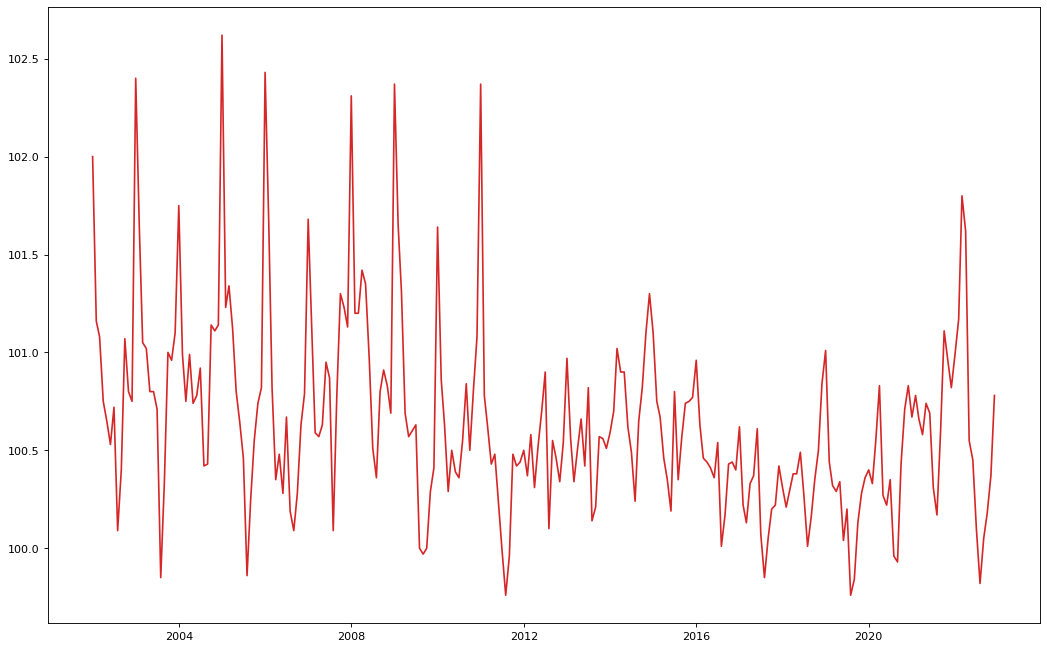

In [13]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(new_data_a["Dates"], new_data_a["Values"], color='tab:red')
plt.show()

### Смотрим корреляцию между рядами данных по годом (12 значений для каждого из с 2000 по 2022 годов)

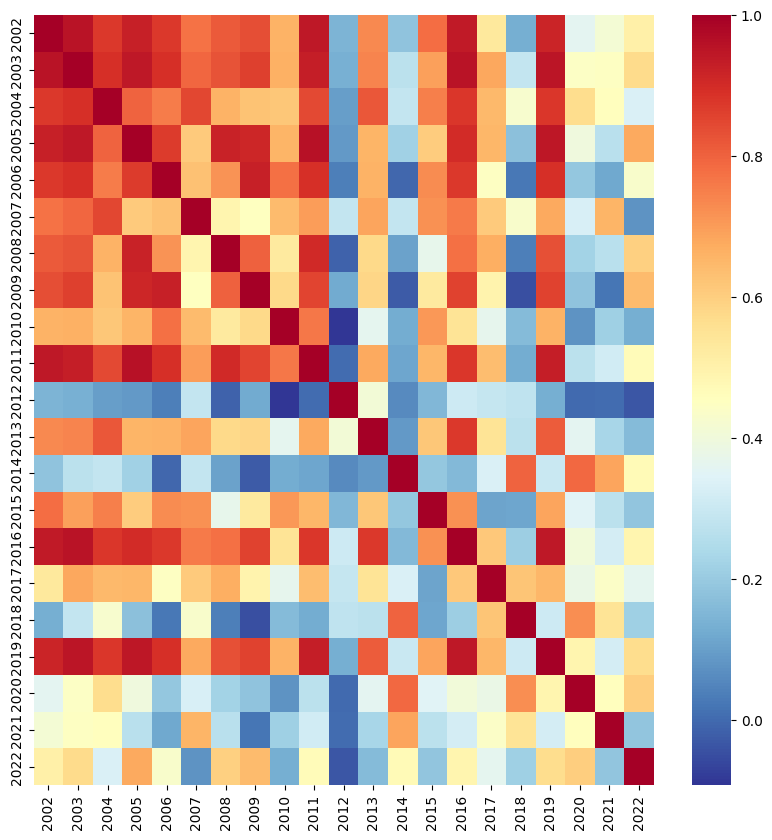

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), cmap="RdYlBu_r");

Хорошо заметно, что, ряды между собой хорошо коррелированы в начальных года, а также в 2019 году. Выбивается сильно 2012 и 2014 года. 2014 - причины понятны, а 2012 - странно. Встречается практически нулевая корреляция между годами. В частности между 2021 и 2022 годами, что можно объяснить известными событиями. Так сама матрица очень интересна!
В целом можно говорить, что ряды помесячных значений в основном имеют хорошую корреляцию.

### Нужно смотреть сезонность, а для этого снача вычислим коэффициенты линейной регрессии

In [15]:
lr = LinearRegression()
x_train = new_data_a[["Dates"]]
# хоть и парная регрессия, но нужно первым параметром lr.fit подобавать именно таблицу!!! Поэтому двойные квадратные скобки
for i in range (21*12):
    x_train.at[i, 'Dates'] = i
y_train = new_data_a["Values"]
#new_data_a.at[267, 'Value'] = 102.0 #убираем выброс март 2022
lr.fit(x_train,y_train)
x_train

,Dates
0,0
1,1
2,2
3,3
4,4
...,...
247,247
248,248
249,249
250,250


In [16]:
print(lr.coef_[0])
print(lr.intercept_)

-0.0023779004066549554
100.94763285024155


In [17]:
lr_values = []
for i in range(21*12):
    lr_value = x_train['Dates'].loc[x_train.index[i]] * lr.coef_[0] + lr.intercept_
    lr_values.append(lr_value)
lr_values

[100.94763285024155,
 100.94525494983489,
 100.94287704942823,
 100.94049914902158,
 100.93812124861493,
 100.93574334820828,
 100.93336544780162,
 100.93098754739496,
 100.9286096469883,
 100.92623174658165,
 100.92385384617499,
 100.92147594576834,
 100.9190980453617,
 100.91672014495504,
 100.91434224454838,
 100.91196434414172,
 100.90958644373507,
 100.90720854332841,
 100.90483064292175,
 100.90245274251511,
 100.90007484210845,
 100.8976969417018,
 100.89531904129514,
 100.89294114088848,
 100.89056324048182,
 100.88818534007517,
 100.88580743966851,
 100.88342953926187,
 100.88105163885521,
 100.87867373844855,
 100.8762958380419,
 100.87391793763524,
 100.87154003722858,
 100.86916213682193,
 100.86678423641528,
 100.86440633600863,
 100.86202843560197,
 100.85965053519531,
 100.85727263478866,
 100.854894734382,
 100.85251683397534,
 100.8501389335687,
 100.84776103316204,
 100.84538313275539,
 100.84300523234873,
 100.84062733194207,
 100.83824943153542,
 100.83587153112876,

In [18]:
new_data_a["LR_Value"] = lr_values

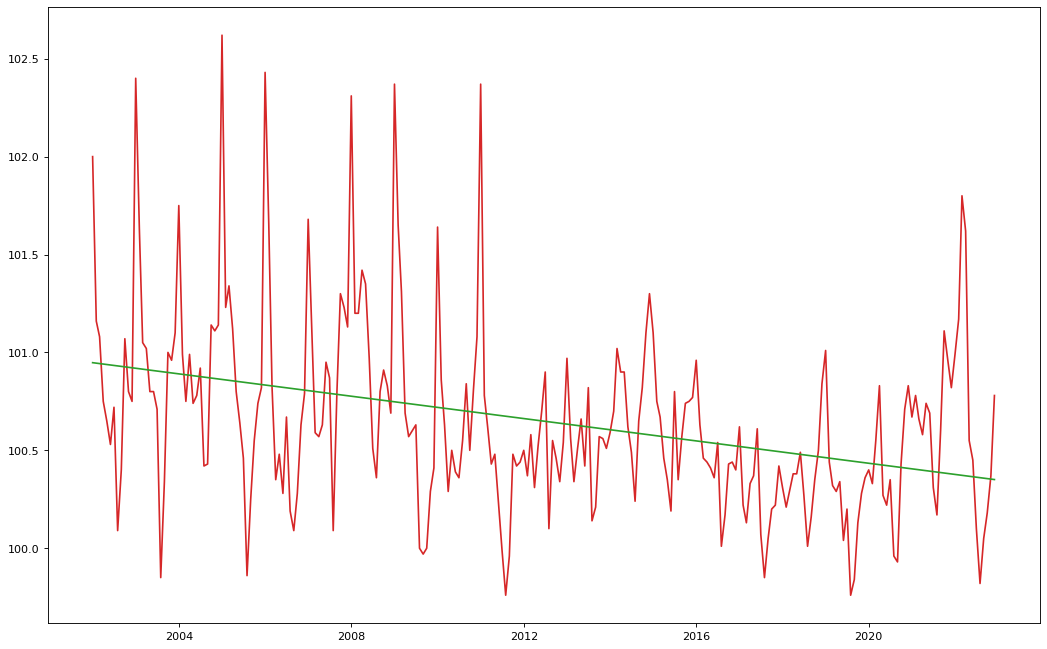

In [19]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(new_data_a["Dates"], new_data_a["Values"], color='tab:red')
plt.plot(new_data_a["Dates"], new_data_a["LR_Value"], color='tab:green')
plt.show()
# Вывели линию регрессии :-)

### По ходу посмотрим статистическую визуализацию: ящик с --ушами--  (ой) с усами, ядерная плотность и гистограмма для всего ряда

<AxesSubplot: >

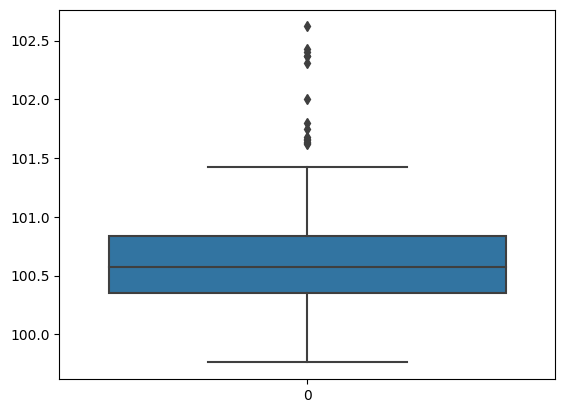

In [20]:
sns.boxplot(data = new_data_a["Values"])

Значения совредоточены между 100,3 и 100,9, выбросы есть, почти до 103...

Строим гистограмму, чтобы сравнить с предыдущей
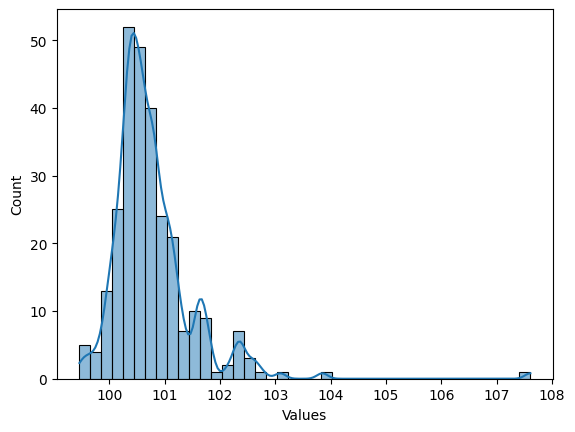

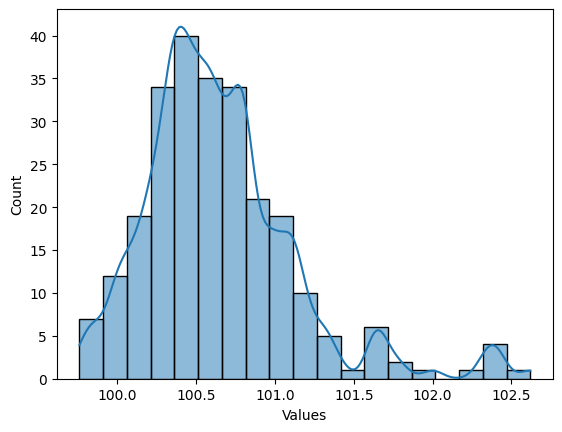

In [21]:
sns.histplot(data=new_data_a["Values"], kde=True, kde_kws={'bw_adjust': 0.4});
# выведем гистрограмму с оценкой плотности распределения ядра со сглаживающей полосой пропускания 0,75 

Визуально можно предположить, что ручное изменение данных в целом не повлияло на характер данных, только выбросы не влияют. 

Строим две диаграммы: 12 графиков до 2011 года включительно и 13 графиков с 2012 по 2022 годы.

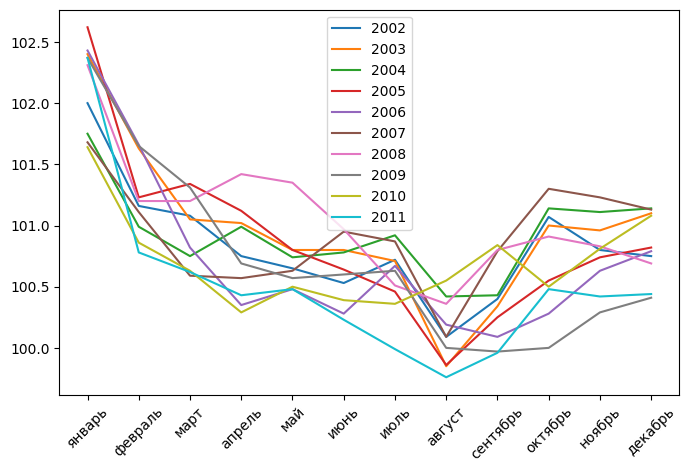

In [22]:
fig, ax = plt.subplots()


for i in range(2002,2012):
    ax.plot(data.index, data[i], label = str(i))
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(8)
plt.xticks(rotation = 45)
plt.show()

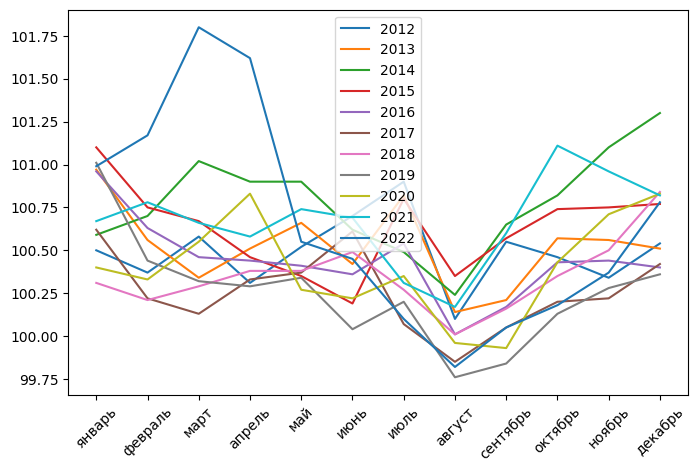

In [23]:
fig, ax = plt.subplots()


for i in range(2012,2023):
    ax.plot(data.index, data[i], label = str(i))
ax.legend()


fig.set_figheight(5)
fig.set_figwidth(8)
plt.xticks(rotation = 45)
plt.show()

2012 смотрится "особняком", 2014 также выделяется, хоть и скорректированный. Но корректировка должна была сохранить направление изменений

### Пройдемся по месячным значениям (21 январьских, 21 февральских и т.д.) и визуализируем для них статистические данные

In [24]:
TData = data.T
# for column in TData:
#    columnSeriesObj = TData[column]    


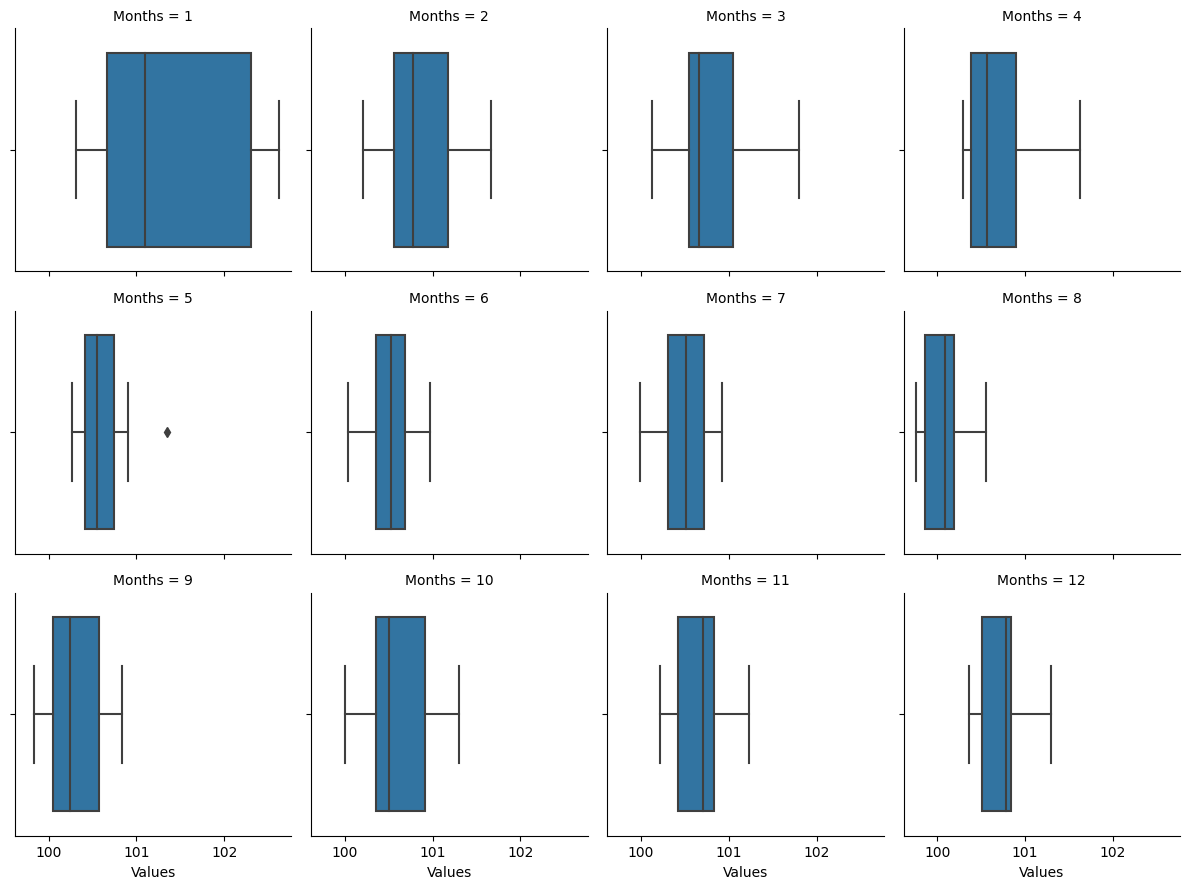

In [25]:
# Визуализируем ящики с усами для каждой колонки (например, янврские даты за все года)
# так можно, но муторно и некрасиво
# for column in TData:
#    columnSeriesObj = TData[column]
#    sns.boxplot(data = columnSeriesObj.values)

# Пробуем так:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.boxplot, 'Values')

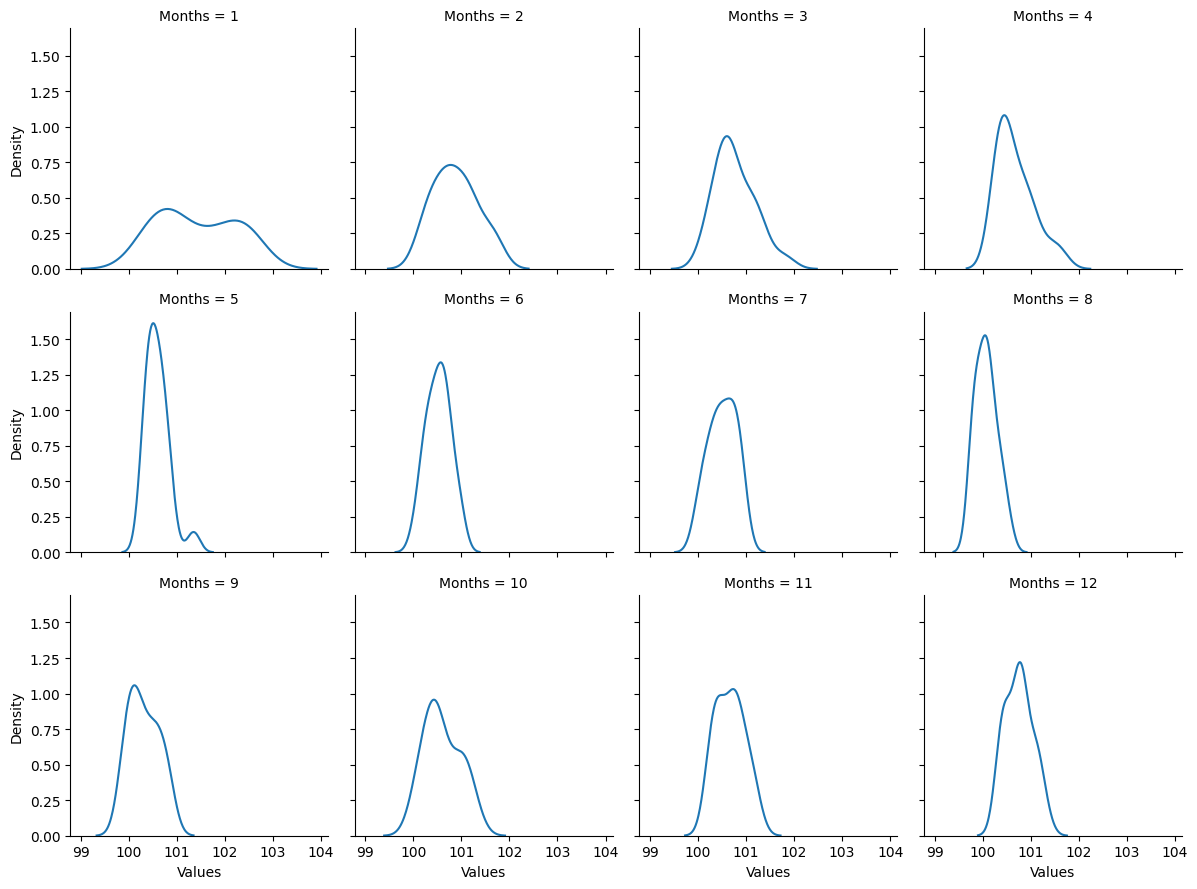

In [26]:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.kdeplot, 'Values')

Сильный разброс в январе смотрится также в виде двуглавой горы, но изменения остальных оценок плотностей заметны

In [27]:
# sns.pairplot(data); 
# не надо этого делать - колонок очень много в исходной таблице - система строит эту "мегаматрицу" в течение 5-7 минут...

### А здесь корректируем данные: фактическое значение делим но вычисленное по модели регрессии - выделяется доля разницы между линейно-трендовым значением и фактическим

In [28]:
new_data_a['Periods'] = new_data_a['Values']/new_data_a['LR_Value']

In [29]:
new_data_a

,Dates,Values,Years,Months,LR_Value,Periods
0,2002-01-01,102.00,2002,1,100.947633,1.010425
1,2002-02-01,101.16,2002,2,100.945255,1.002127
2,2002-03-01,101.08,2002,3,100.942877,1.001358
3,2002-04-01,100.75,2002,4,100.940499,0.998113
4,2002-05-01,100.65,2002,5,100.938121,0.997146
...,...,...,...,...,...,...
247,2022-08-01,99.82,2022,8,100.360291,0.994616
248,2022-09-01,100.05,2022,9,100.357914,0.996932
249,2022-10-01,100.18,2022,10,100.355536,0.998251
250,2022-11-01,100.37,2022,11,100.353158,1.000168


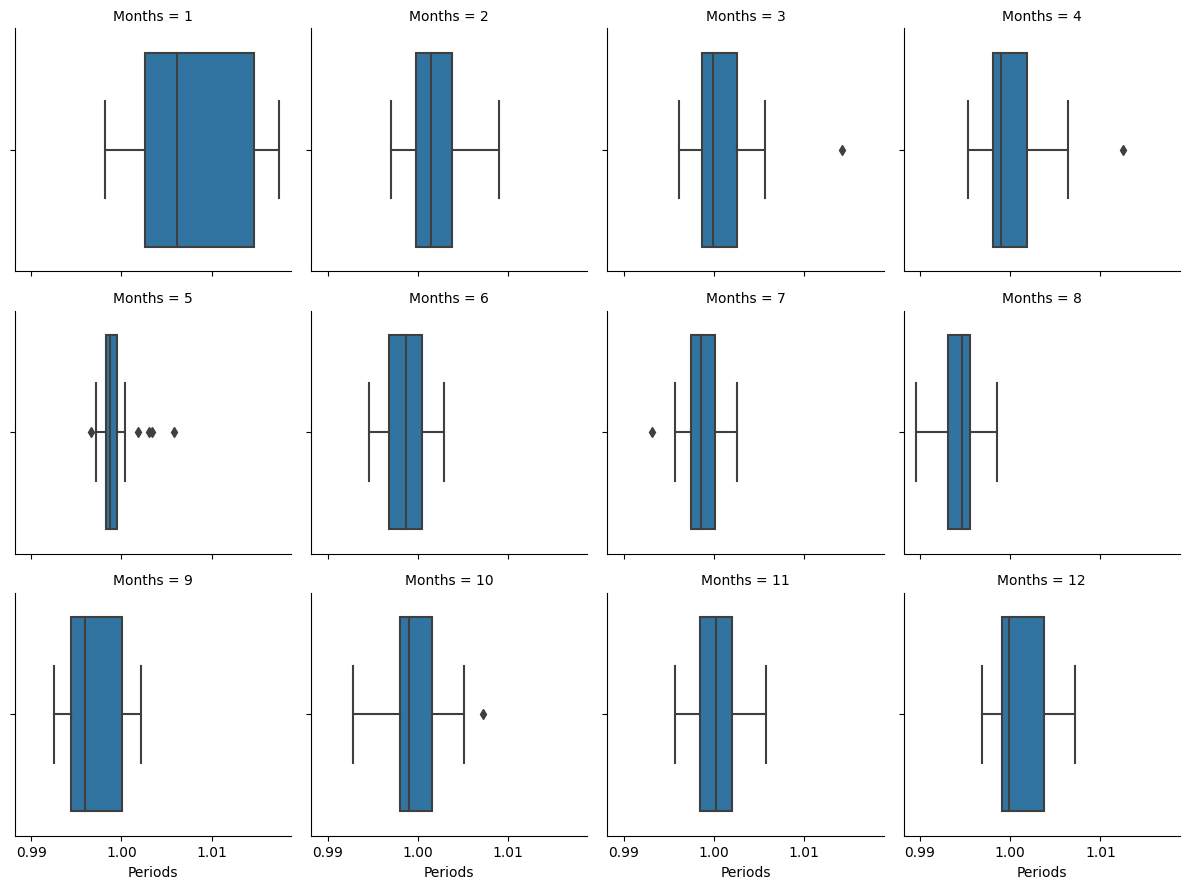

In [30]:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.boxplot, 'Periods')

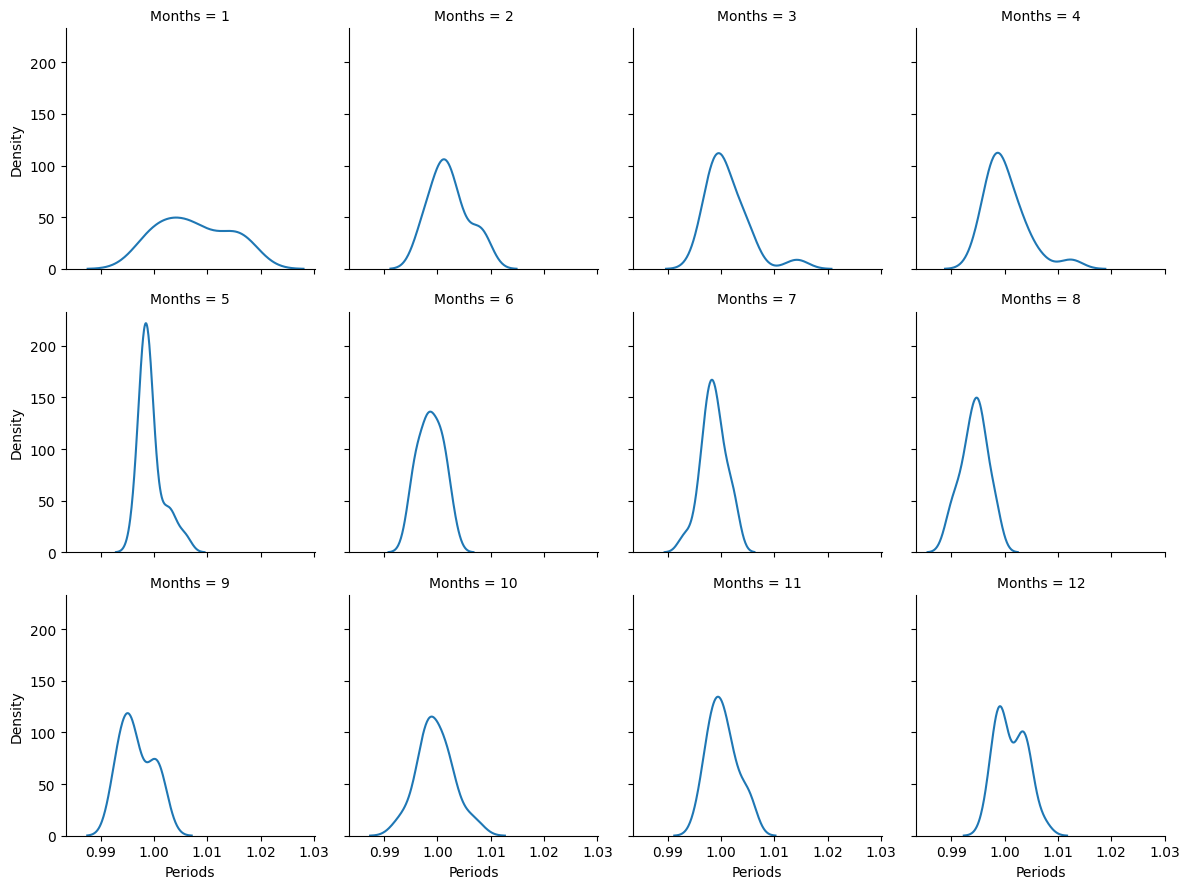

In [31]:
g = sns.FacetGrid (data=new_data_a, col='Months', col_wrap=4, legend_out=False)
g.map (sns.kdeplot, 'Periods')

## Строим "Бейзлайн"

Базовое решение или "Бейзлайн" будет строиться на основе стандартной модели Хольта-Уинтерса с параметрами сглаживания: 0,1; 0,2; 0,3.

In [32]:
df_train = new_data_a["Values"].iloc[:-24]
# Для тестирования оставляем 2022 год
df_test = new_data_a["Values"].iloc[-24:]

In [33]:
# Создаем и обучаем модель Хольта-Уинтерса: тренд добавляется, а сезонность - умножается
model = HW_Model(df_train, seasonal_periods = 12, trend = "add", seasonal = "mul")
fit_model = model.fit(smoothing_level = 0.1, smoothing_trend = 0.2, smoothing_seasonal = 0.3)

Сводка для исходной выборки:
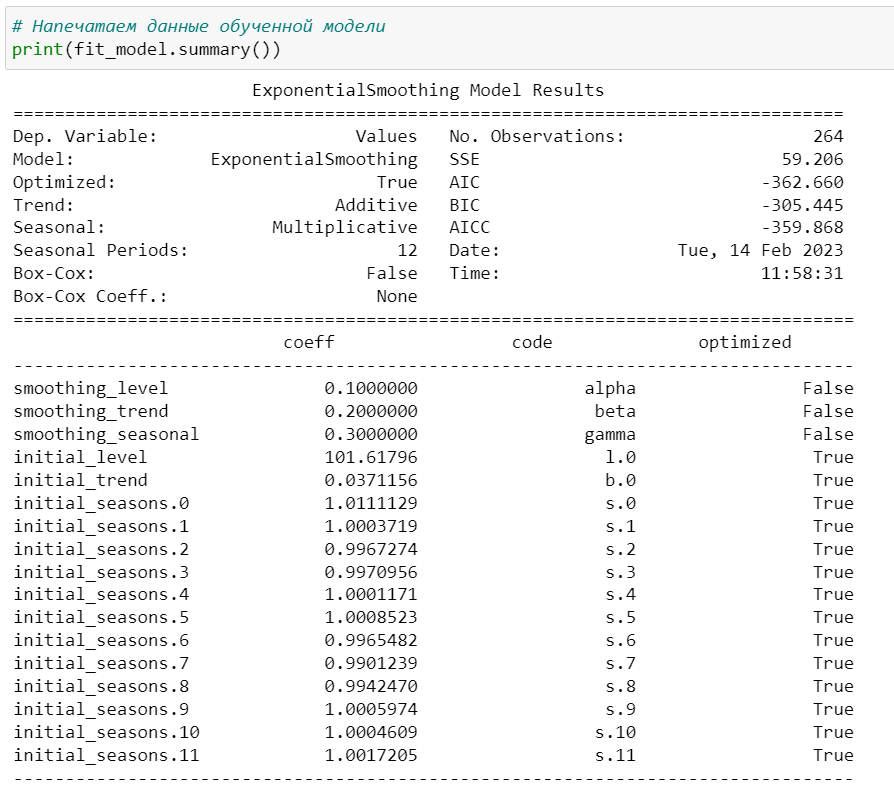

In [34]:
# Напечатаем данные обученной модели
print(fit_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  228
Model:             ExponentialSmoothing   SSE                             25.579
Optimized:                         True   AIC                           -466.763
Trend:                         Additive   BIC                           -411.894
Seasonal:                Multiplicative   AICC                          -463.490
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend          

In [35]:
CPI_forecast = fit_model.forecast(steps=24)

In [36]:
CPI_forecast

228    100.733785
229    100.483486
230    100.536840
231    100.639003
232    100.486265
233    100.439772
234    100.493446
235    100.129392
236    100.252919
237    100.585809
238    100.755422
239    100.817233
240    100.958424
241    100.707525
242    100.760957
243    100.863306
244    100.710185
245    100.663548
246    100.717299
247    100.352394
248    100.476154
249    100.809743
250    100.979693
251    101.041599
dtype: float64

In [37]:
df_test

228    100.67
229    100.78
230    100.66
231    100.58
232    100.74
233    100.69
234    100.31
235    100.17
236    100.60
237    101.11
238    100.96
239    100.82
240    100.99
241    101.17
242    101.80
243    101.62
244    100.55
245    100.45
246    100.10
247     99.82
248    100.05
249    100.18
250    100.37
251    100.78
Name: Values, dtype: float64

In [38]:
# Готовим данные для показа реальных данных 2021, 2022 годов,
# спрогнозированных данных на 2021-2022 годы.
real_local = []
for_local = []
dates_local = []
curr_date = datetime(day=1, month=1, year=2021)
for i in range(24): 
    days_in_month = calendar.monthrange(curr_date.year, curr_date.month)[1]
    dates_local.append(curr_date)
    curr_date = curr_date  + timedelta(days=days_in_month)
    real_local.append(new_data_a["Values"].iloc[227+i])
    for_local.append(CPI_forecast.iloc[i])
DF_show = pd.DataFrame()
DF_show["Dates"] = dates_local
DF_show["Real"] = real_local
DF_show["Forecast"] = for_local

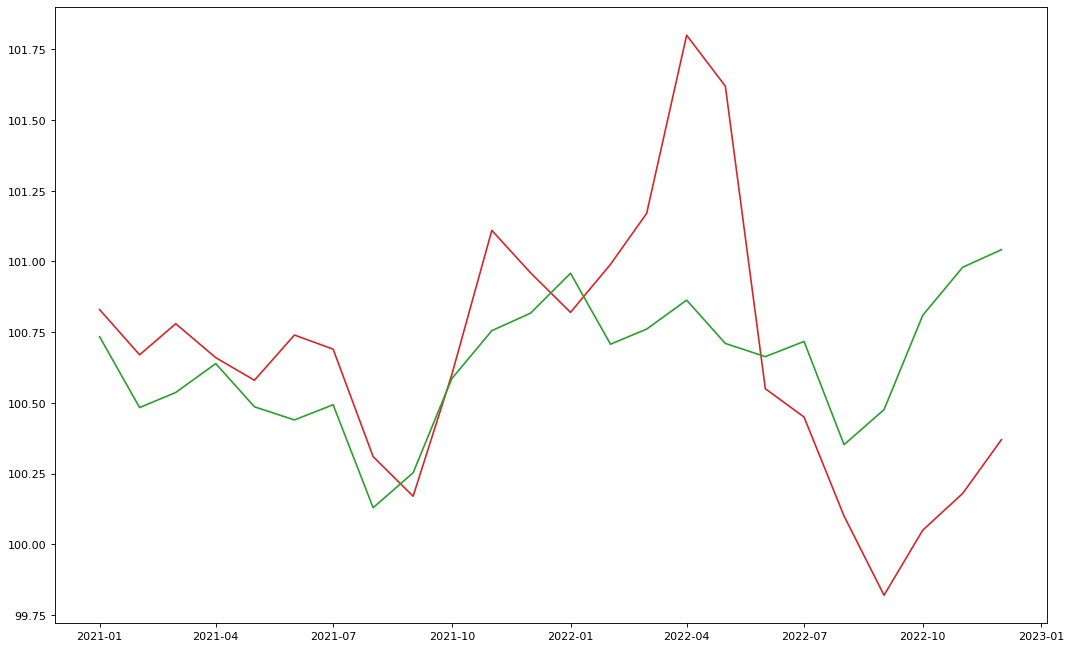

In [39]:
# сравнение реальных значение с прогнозыми (2022 год)
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(dates_local, real_local, color='tab:red')
plt.plot(dates_local, for_local, color='tab:green')
plt.show()

In [40]:
APE = []
for i in range(24):
    per_err = abs((real_local[i] - for_local[i])/real_local[i])
    APE.append(per_err)
MAPE = sum(APE)/len(APE)
print('Средняя относительная ошибка: ' + str(MAPE))

Средняя относительная ошибка: 0.0033542906085995707


Бейзлайн плохонький даже при такой малой ошибке (была ранее до корректировок 0.012680626467093897). Параметры сглаживания подобраны "на обум"...
Хотя в 2021 году моделька "уловила" сезоны. В 2022 годы данные корретировались, но так, чтобы изменения сохранялись по отношению к исходному варианту. График это подтвердил. 
Необходимо подбирать гиперпараметры, в том числе методом кросс-валидации.

### Строим улучшенную модель, на кросс-валиации оптимизируем гиперпараметры

In [41]:
# Работаем над фолдами:
TSCV = TimeSeriesSplit(n_splits=7, test_size=24)
TSCV
# Шаблончик разбиения получился

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=24)

In [42]:
# Нарезаем данные
for i, (train_index, test_index) in enumerate(TSCV.split(new_data_a[["Values"]])):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
# То, что выведено ниже - карта разбиений на обучающие и тестовые выборки (указаны индексы значений)

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
  Test:  index=[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107]
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
  Test:  index=[108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131]
Fold 2:
  Train: index=[  0   

In [43]:
# А теперь ищем лучшее, делаем соответсвующую функцию:

In [44]:
def FoldsScore(HyperParams):
    
    values = new_data_a["Values"]
    Err = []
    alpha, beta, gamma = HyperParams
    
    TSCV = TimeSeriesSplit(n_splits=7, test_size=24) 
    # Сделали шаблон для разбивки на фолды (см. выше)
    
    
    
    for train, test in TSCV.split(values):
       model = HW_Model(endog = values[train], seasonal_periods = 12, trend = "add", seasonal = "mul") 
       fit_model = model.fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal = gamma) 
       print(fit_model.summary()) 
       predictions = fit_model.forecast(steps=24)
       actual = values[test]
       error = mean_squared_error(predictions, actual) 
       Err.append(error) 
    
    # print(Err)
    return np.min(np.array(Err))
#        model = HW_Model(df_train, seasonal_periods = 12, trend = "add", seasonal = "mul")
#        fit_model = model.fit(smoothing_level = 0.1, smoothing_trend = 0.2, smoothing_seasonal = 0.3)
        
        
        
        
      
    
    
    

In [45]:
# Поиграемся с моделькой: в x вкладываем параметры сглаживания
x = [0.3, 0.4, 0.1]
NumF = 1;
FoldsScore(x)
print(x)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                   84
Model:             ExponentialSmoothing   SSE                              5.969
Optimized:                         True   AIC                           -190.109
Trend:                         Additive   BIC                           -151.216
Seasonal:                Multiplicative   AICC                          -179.586
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha                False
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  180
Model:             ExponentialSmoothing   SSE                             23.143
Optimized:                         True   AIC                           -337.229
Trend:                         Additive   BIC                           -286.142
Seasonal:                Multiplicative   AICC                          -332.980
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha                False
smoothing_trend          

Самое нижнее значение AIC -452, а в бейзлайн - -466. Лучше не стало. **Оптимизируем параметры сглаживания**

In [46]:
%%time
data = new_data_a["Values"].iloc[:-24]
# отложили выборку для окончательного тестирования

x = [0, 0, 0]
# начальные параметры сглаживания по нулям
opt = minimize(FoldsScore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x

print(alpha_final, beta_final, gamma_final)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                   84
Model:             ExponentialSmoothing   SSE                              5.321
Optimized:                         True   AIC                           -199.769
Trend:                         Additive   BIC                           -160.876
Seasonal:                Multiplicative   AICC                          -189.246
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level                0.000000                alpha                False
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  204
Model:             ExponentialSmoothing   SSE                             20.733
Optimized:                         True   AIC                           -434.422
Trend:                         Additive   BIC                           -381.332
Seasonal:                Multiplicative   AICC                          -430.725
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level                0.000000                alpha                False
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  156
Model:             ExponentialSmoothing   SSE                             16.635
Optimized:                         True   AIC                           -317.184
Trend:                         Additive   BIC                           -268.386
Seasonal:                Multiplicative   AICC                          -312.191
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level                   1e-08                alpha                False
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                             12.522
Optimized:                         True   AIC                           -278.896
Trend:                         Additive   BIC                           -232.772
Seasonal:                Multiplicative   AICC                          -272.843
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level                0.000000                alpha                False
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                   84
Model:             ExponentialSmoothing   SSE                              5.321
Optimized:                         True   AIC                           -199.769
Trend:                         Additive   BIC                           -160.876
Seasonal:                Multiplicative   AICC                          -189.246
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level                0.000000                alpha                False
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  204
Model:             ExponentialSmoothing   SSE                             20.733
Optimized:                         True   AIC                           -434.422
Trend:                         Additive   BIC                           -381.332
Seasonal:                Multiplicative   AICC                          -430.725
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level                0.000000                alpha                False
smoothing_trend          

А здесь получилось AIC стало -498. Не намного, но улучшили. Как видно - испльзован фолд с самой длинной обучающей выборкой.
Получим модель отдельно и выполним прогноз.

In [47]:
# Создаем и обучаем модель Хольта-Уинтерса: делаем тоже самое, но для параметров сглаживания 0, 0, 0
model = HW_Model(df_train, seasonal_periods = 12, trend = "add", seasonal = "mul")
fit_model = model.fit(smoothing_level = 0, smoothing_trend = 0, smoothing_seasonal = 0)
print(fit_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Values   No. Observations:                  228
Model:             ExponentialSmoothing   SSE                             22.292
Optimized:                         True   AIC                           -498.125
Trend:                         Additive   BIC                           -443.255
Seasonal:                Multiplicative   AICC                          -494.852
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         21:29:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level                0.000000                alpha                False
smoothing_trend          

In [48]:
CPI_forecast = fit_model.forecast(steps=24)

Повторяем действия для визуализации

In [49]:
# Готовим данные для показа реальных данных 2021, 2022 годов,
# спрогнозированных данных на 2021-2022 годы.
real_local = []
for_local = []
dates_local = []
curr_date = datetime(day=1, month=1, year=2021)
for i in range(24): 
    days_in_month = calendar.monthrange(curr_date.year, curr_date.month)[1]
    dates_local.append(curr_date)
    curr_date = curr_date  + timedelta(days=days_in_month)
    real_local.append(new_data_a["Values"].iloc[227+i])
    for_local.append(CPI_forecast.iloc[i])
DF_show = pd.DataFrame()
DF_show["Dates"] = dates_local
DF_show["Real"] = real_local
DF_show["Forecast"] = for_local

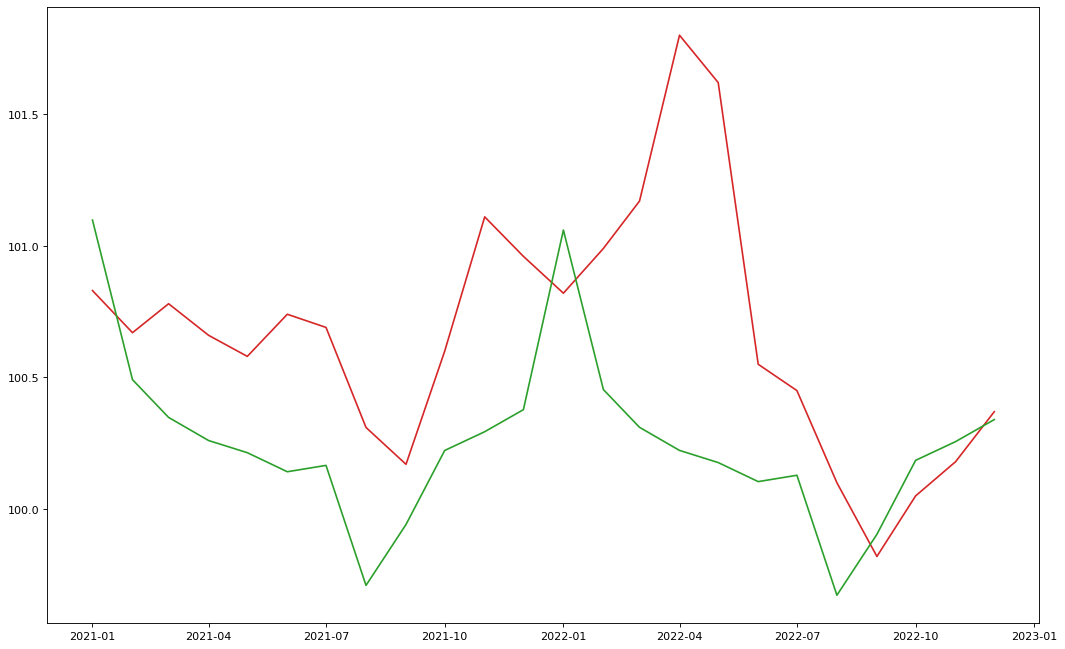

In [50]:
# сравнение реальных значение с прогнозыми (2022 год)
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(dates_local, real_local, color='tab:red')
plt.plot(dates_local, for_local, color='tab:green')
plt.show()

А было так:
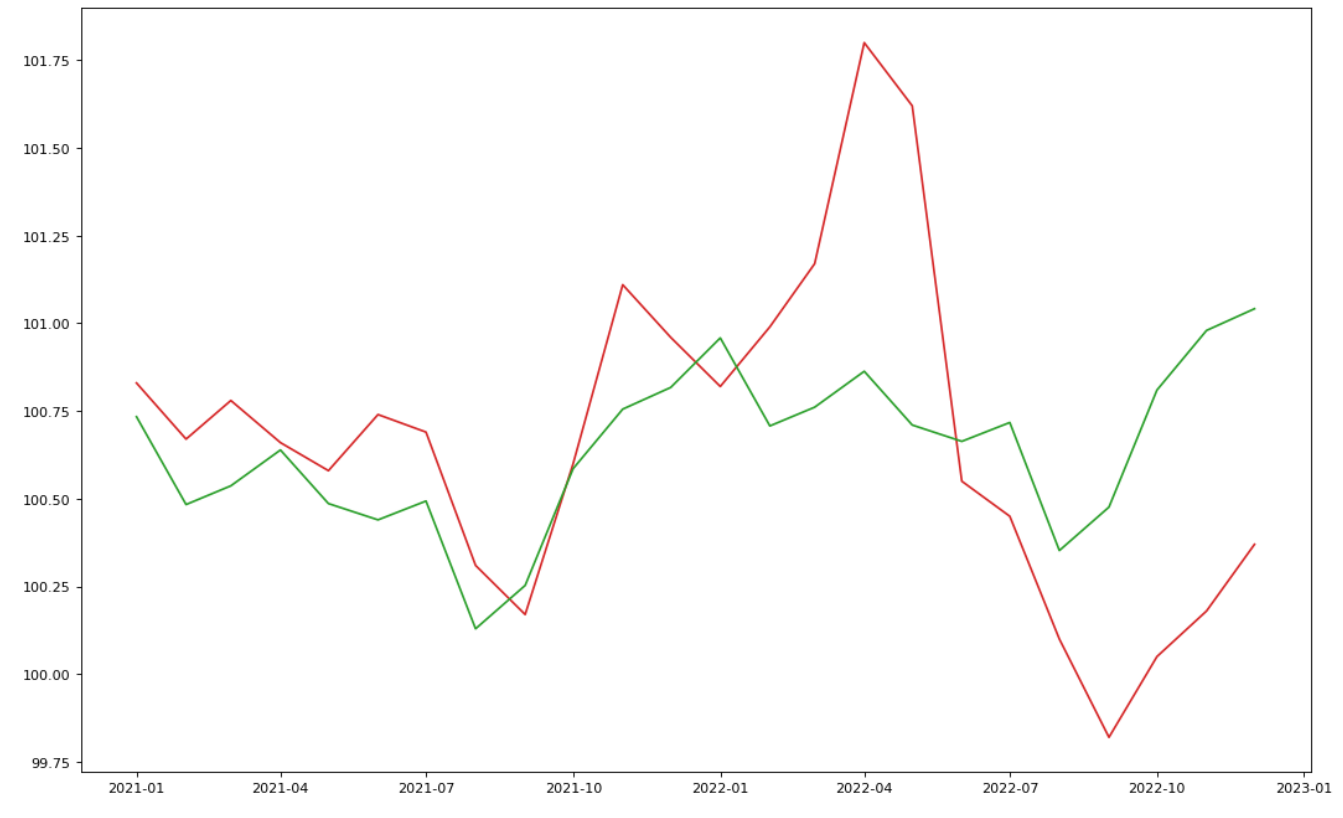

Сложно понять, что лучше. Берем метрики.
Снова вычисляем MAPE

In [51]:
APE = []
for i in range(24):
    per_err = abs((real_local[i] - for_local[i])/real_local[i])
    APE.append(per_err)
MAPE = sum(APE)/len(APE)
print('Средняя относительная ошибка: ' + str(MAPE))

Средняя относительная ошибка: 0.0047647337363367235


В бейзлайне (БЛ) на скорректриованных данных ошибка была 0.0033542906085995707. Получается, по данной метрике, бейзлайн лучше, чем улучшенный вариант (УВ),  но это по метрике MAPE, а по метрикам SSE и AIC получается:

SSE: БЛ -  25.58, УВ -  22.29 

AIC: БЛ - -466.76, УВ - -498.12

Эти метрики улучшились!

**Вот, что значит выбрать метрику!!!**

Сравним с бейзлайном, полученных на начальных данных (БН):

MAPE: БН -    0.0127, БЛ -    0.0034, УВ -    0.0048

SSE:  БН -   59.21,   БЛ -   25.58,   УВ -   22.29 

AIC:  БН - -362.66,   БЛ - -466.76,   УВ - -498.12

Степень вклада за счет корректировки данных ощутима!

А теперь посмотрим критерии адекватности модели

In [52]:
# Источник кода этой функции (https://question-it.com/questions/1319878/nahozhdenie-povorotnyh-tochek-massiva-v-pitone?ysclid=le4issql1w267966464)
# Эта функция вычисляет число поворотных точек
def turns(L):
     answer, delta = 0, -1 if L[1]<L[0] else 1
     i = 2
     while i < len(L):
             d = -1 if L[i]<L[i-1] else 1
             if d != delta:
                     answer += 1
                     delta = d
             i += 1
     return answer

In [53]:
#Критерий поворотных точек
print('Число поворотных точек: ', turns(fit_model.resid))
tp_krit = int(2/3*(228-2)-1.96*math.sqrt((16*228-29)/90))
print('Критическое значение числа поворотных точек: ', tp_krit, ' - noOk')

#Критерия Дарбина-Уотсона
print('Значение статистики Дарбина-Уотсона: ', durbin_watson(fit_model.resid))

Число поворотных точек:  119
Критическое значение числа поворотных точек:  138  - noOk
Значение статистики Дарбина-Уотсона:  0.9384032390342674


Адекватность модели вызывает сомнения (гипотезы случайности и независимости остатков отвергаются). В этом случае она может быть использована "на свой страх и риск"!